# Logit Lens Demo

In [1]:
!nvidia-smi

Fri Jul 14 11:33:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           On | 00000000:56:00.0 Off |                    0 |
| N/A   27C    P0               53W / 300W|      0MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import pickle

sys.path.append("../../dev")
from utils import *
from model import *
from prefixes import *
from metrics import *
from visualize import *

sys.path.append("../../model")
from model_params import *

sys.path.append("../../data")
from dataset_params import *
from prompt_params import *
from demo_params import *

## 1) Setup

Pick \
(1) Model (gpt_j, gpt2_xl, gpt_neox) \
(2) Dataset (sst2, unnatural, agnews, etc) \
(3) Setting (permuted_incorrect_labels, half_permuted_incorrect_labels, random_labels, etc) \

In [4]:
model = "gpt_j"
dataset = "sst2"
setting = "permuted_incorrect_labels"
prompt_format_indx = 0 # use first prompt format
num_inputs = 250
num_demos = 40

In [5]:
model_params = MODEL_PARAMS[model]
dataset_params = DATASET_PARAMS[dataset]
prompt_params = PROMPT_PARAMS[dataset][prompt_format_indx]
demo_params = DEMO_PARAMS[setting]

## 2) Get Model and Tokenizer

In [6]:
file_path = model_params["file_path"]
model, tokenizer = get_model_and_tokenizer(file_path)

## 3) Get Dataset

In [7]:
print("*Fetch data.*")
dataset = get_dataset(dataset_params)

print(f"There are {len(dataset)} classes.")
print(f"There are {len(dataset[0])} examples per class.")

*Fetch data.*


Found cached dataset sst2 (/tmp/.xdg_cache_dhalawi/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


There are 2 classes.
There are 29780 examples per class.


## 4) Construct Prefixes

In [8]:
print("*Build prefixes.*")
prefixes = Prefixes(dataset, prompt_params, demo_params, model_params, tokenizer, num_inputs, num_demos)

print("True prefix example:")
print("--------------------")
print(prefixes.true_prefixes[0])

print("False prefix example:")
print("---------------------")
print(prefixes.false_prefixes[0])

*Build prefixes.*
True prefix example:
--------------------
Review: succeeds where its recent predecessor miserably fails because it demands that you suffer the dreadfulness of war from both sides . 
Answer: Positive.

Review: positive ( if tragic ) note 
Answer: Positive.

Review: is a genuinely bone-chilling tale . 
Answer: Positive.

Review: in its own floundering way , it gets to you . 
Answer: Positive.

Review: his most critically insightful 
Answer: Positive.

Review: a chilly , brooding but quietly resonant psychological study of domestic tension and unhappiness 
Answer: Positive.

Review: farewell-to-innocence movies 
Answer: Negative.

Review: entertaining from start to finish , featuring a fall from grace that still leaves shockwaves 
Answer: Positive.

Review: becomes too heavy for the plot . 
Answer: Negative.

Review: once the downward spiral comes to pass , auto focus bears out as your typical junkie opera ... 
Answer: Negative.

Review: a captivatingly quirky hybrid of 

## 5) Run Inference

In [9]:
print(
    "*Run inference and get top 1 intermediate logit, top number of labels intermediate logits, probabilities of labels, and normalized probabilities of labels.*"
)
top_1_logit, top_num_labels_logits, probs, norm_probs = get_label_probs_and_top_logits(
    model, prefixes,
)

*Run inference and get top 1 intermediate logit, top number of labels intermediate logits, probabilities of labels, and normalized probabilities of labels.*
0/500 inputs processed
10/500 inputs processed
20/500 inputs processed
30/500 inputs processed
40/500 inputs processed
50/500 inputs processed
60/500 inputs processed
70/500 inputs processed
80/500 inputs processed
90/500 inputs processed
100/500 inputs processed
110/500 inputs processed
120/500 inputs processed
130/500 inputs processed
140/500 inputs processed
150/500 inputs processed
160/500 inputs processed
170/500 inputs processed
180/500 inputs processed
190/500 inputs processed
200/500 inputs processed
210/500 inputs processed
220/500 inputs processed
230/500 inputs processed
240/500 inputs processed
250/500 inputs processed
260/500 inputs processed
270/500 inputs processed
280/500 inputs processed
290/500 inputs processed
300/500 inputs processed
310/500 inputs processed
320/500 inputs processed
330/500 inputs processed
340/

## 6) Metrics: Top-1 Accuracy, Top Number of Labels Match, Label Space Probability, Correct over Incorrect

In [10]:
print("*Compute top_1_acc metric.*")
top_1_acc = get_top_1_acc(
    top_1_logit, prefixes.true_prefixes_labels, prefixes.lab_first_token_ids
)

*Compute top_1_acc metric.*


In [11]:
print("*Compute top_num_labels_match metric.*")
top_num_labels_match = get_top_num_labels_match(
    top_num_labels_logits, prefixes.lab_first_token_ids
)

*Compute top_num_labels_match metric.*


In [12]:
print("*Compute label_space metric.*")
label_space_probs = mean_up_low(torch.sum(probs, -1))

*Compute label_space metric.*


In [13]:
print("*Get probability of correct labels.*")
correct_label_probs = get_correct_label_probs(
    probs, prefixes.true_prefixes_labels
)

*Get probability of correct labels.*


In [14]:
print("*Compute correct_over_incorrect metric.*")
n_labels = norm_probs.shape[-1]
correct_over_incorrect = (correct_label_probs >= torch.max(probs, -1).values).float()
correct_over_incorrect = mean_up_low(correct_over_incorrect)

del correct_label_probs
torch.cuda.empty_cache()

*Compute correct_over_incorrect metric.*


## 7) Calibrated Metrics: Calibrated Correct over Incorrect, Calibrated Permute Score

In [15]:
print("*Get quantile probabilities of labels for calibration.*")
n_labels = norm_probs.shape[-1]
quantiles, means = get_thresholds(norm_probs, n_labels)

*Get quantile probabilities of labels for calibration.*


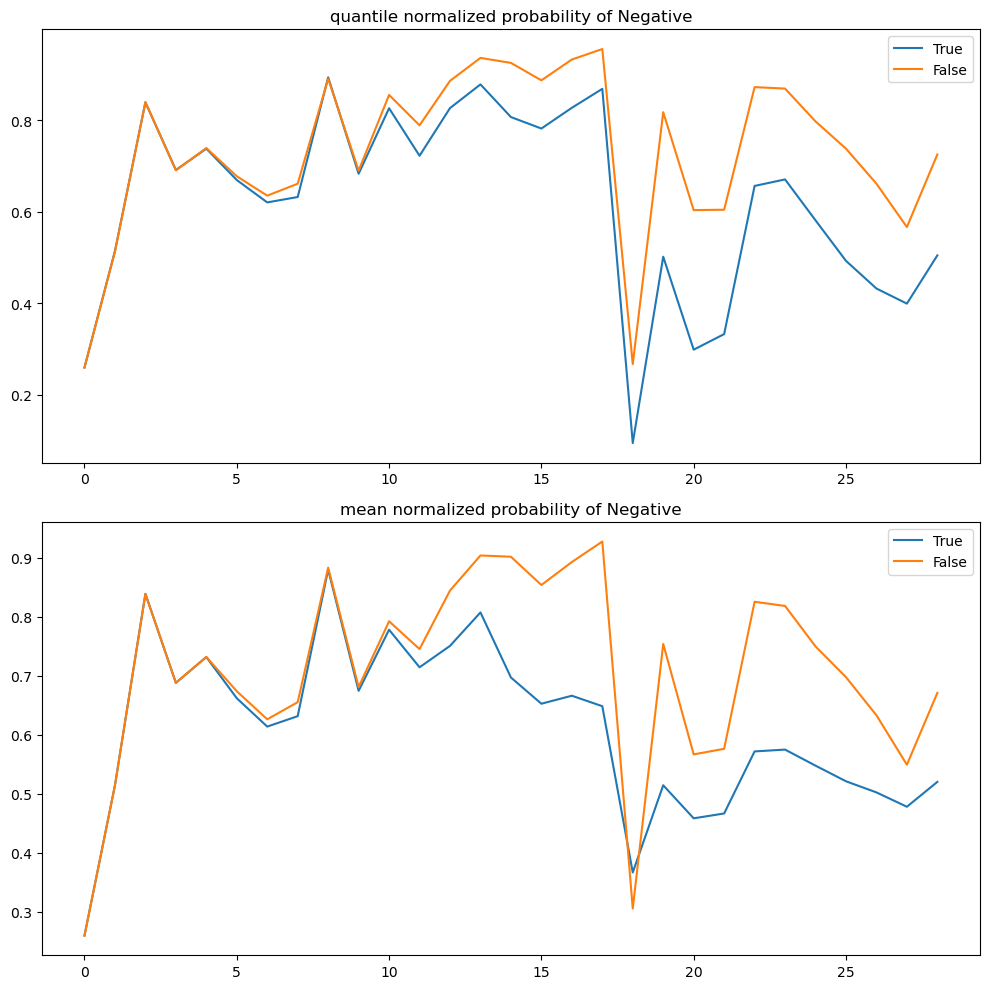

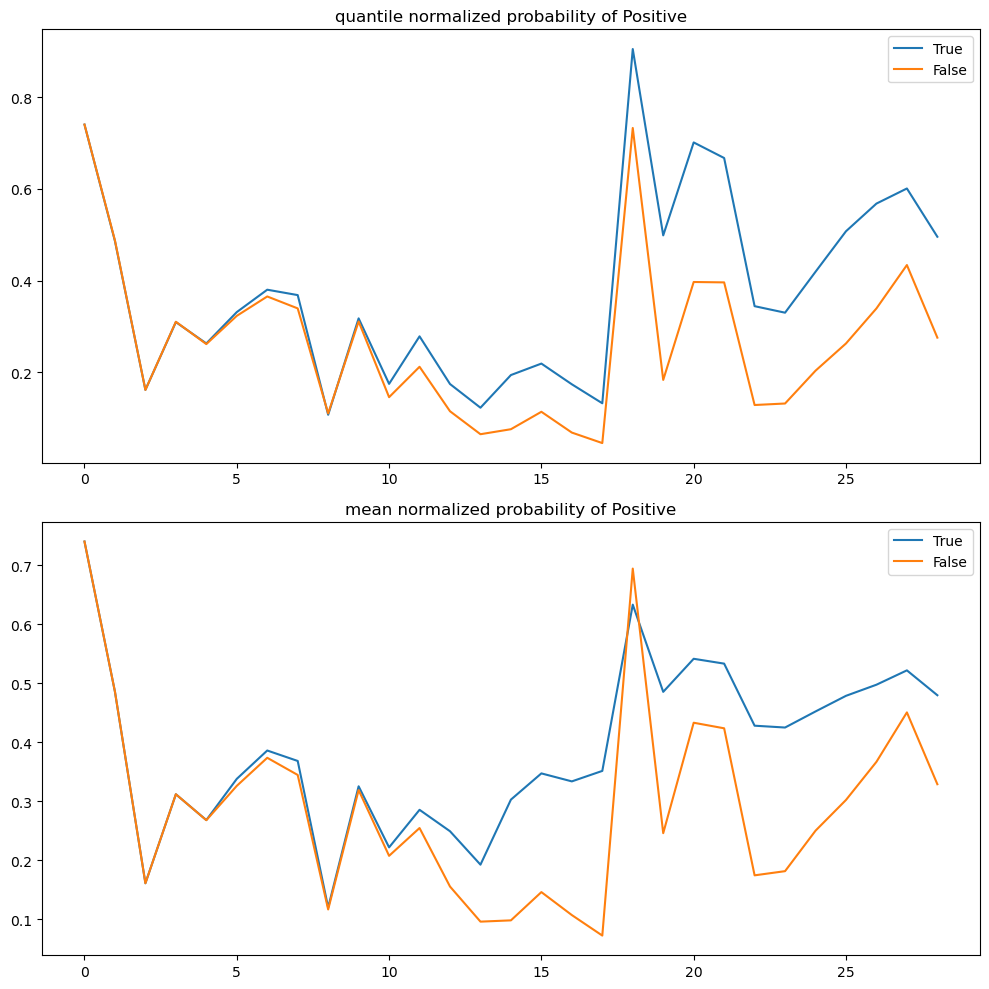

In [16]:
context_pos = -1
labels = prompt_params["labels"]
for i in range(len(labels)):
    thresholds = {
        "quantile": quantiles[:, :, :, context_pos, i],
        "mean": means[:, :, :, context_pos, i],
    }
    plot_label_thresholds(thresholds, labels[i], ["True", "False"])

In [17]:
print("*Compute cal_correct_over_incorrect metric.*")
cal_correct_over_incorrect = get_cal_correct_over_incorrect(
    norm_probs, quantiles, prefixes.true_prefixes_labels
)

*Compute cal_correct_over_incorrect metric.*


In [18]:
print("*Compute cal_permute metric.*")
cal_permute = get_cal_permute(norm_probs, quantiles, prefixes.false_prefixes_labels)

del norm_probs
del probs
del quantiles
del means
torch.cuda.empty_cache()

*Compute cal_permute metric.*


## 8) Plot Calibrated Accuracy

In [19]:
metrics = {
    "cal_correct_over_incorrect": cal_correct_over_incorrect,
}

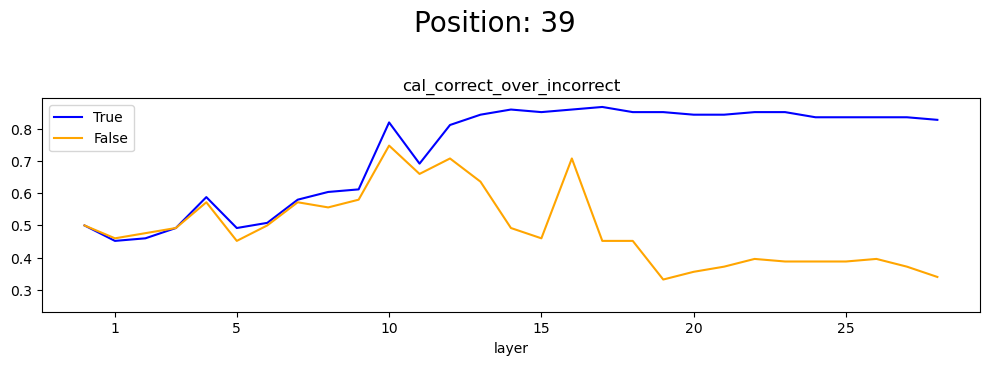

In [20]:
context_pos = model_params["max_demos"] - 1  # index of last demonstration
plot_layerwise_metric_curves(metrics, context_pos=context_pos, show_confidence=False)

## 9) Plot All Metrics

In [21]:
metrics = {
    "label_space_probs": label_space_probs,
    "top_num_labels_match": top_num_labels_match,
    "top_1_acc": top_1_acc,
    "correct_over_incorrect": correct_over_incorrect,
    "cal_correct_over_incorrect": cal_correct_over_incorrect,
    "cal_permute": cal_permute,
}

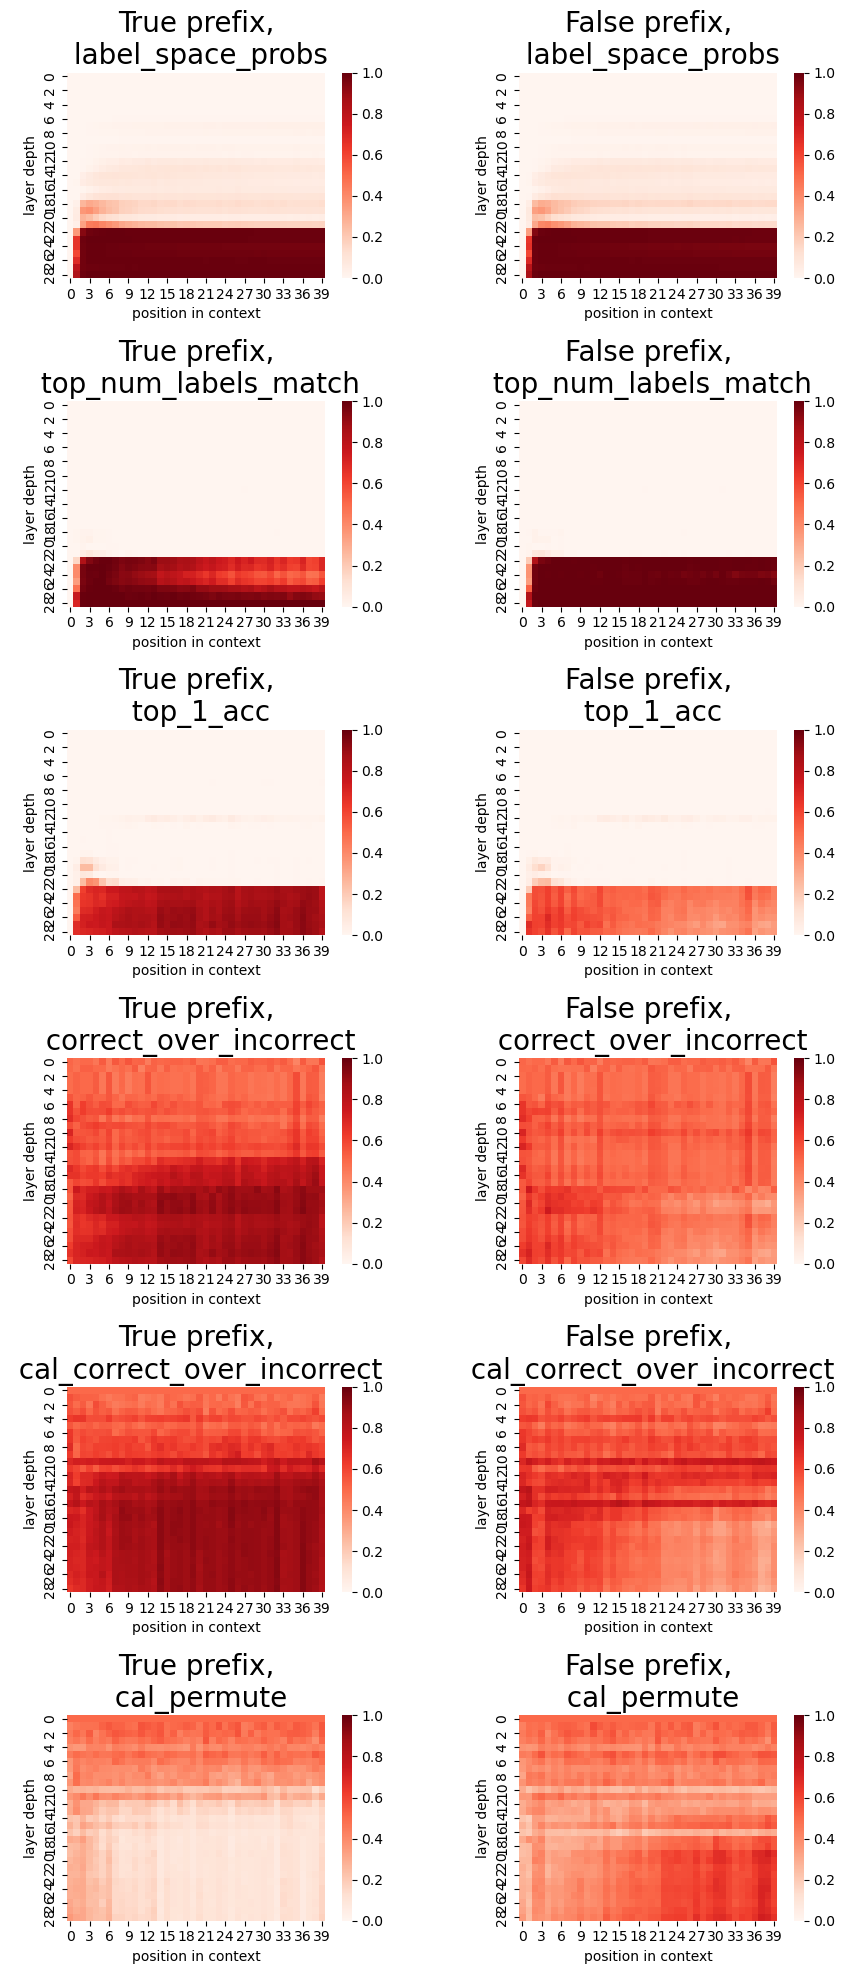

In [22]:
plot_layerwise_metric_heatmaps(metrics)

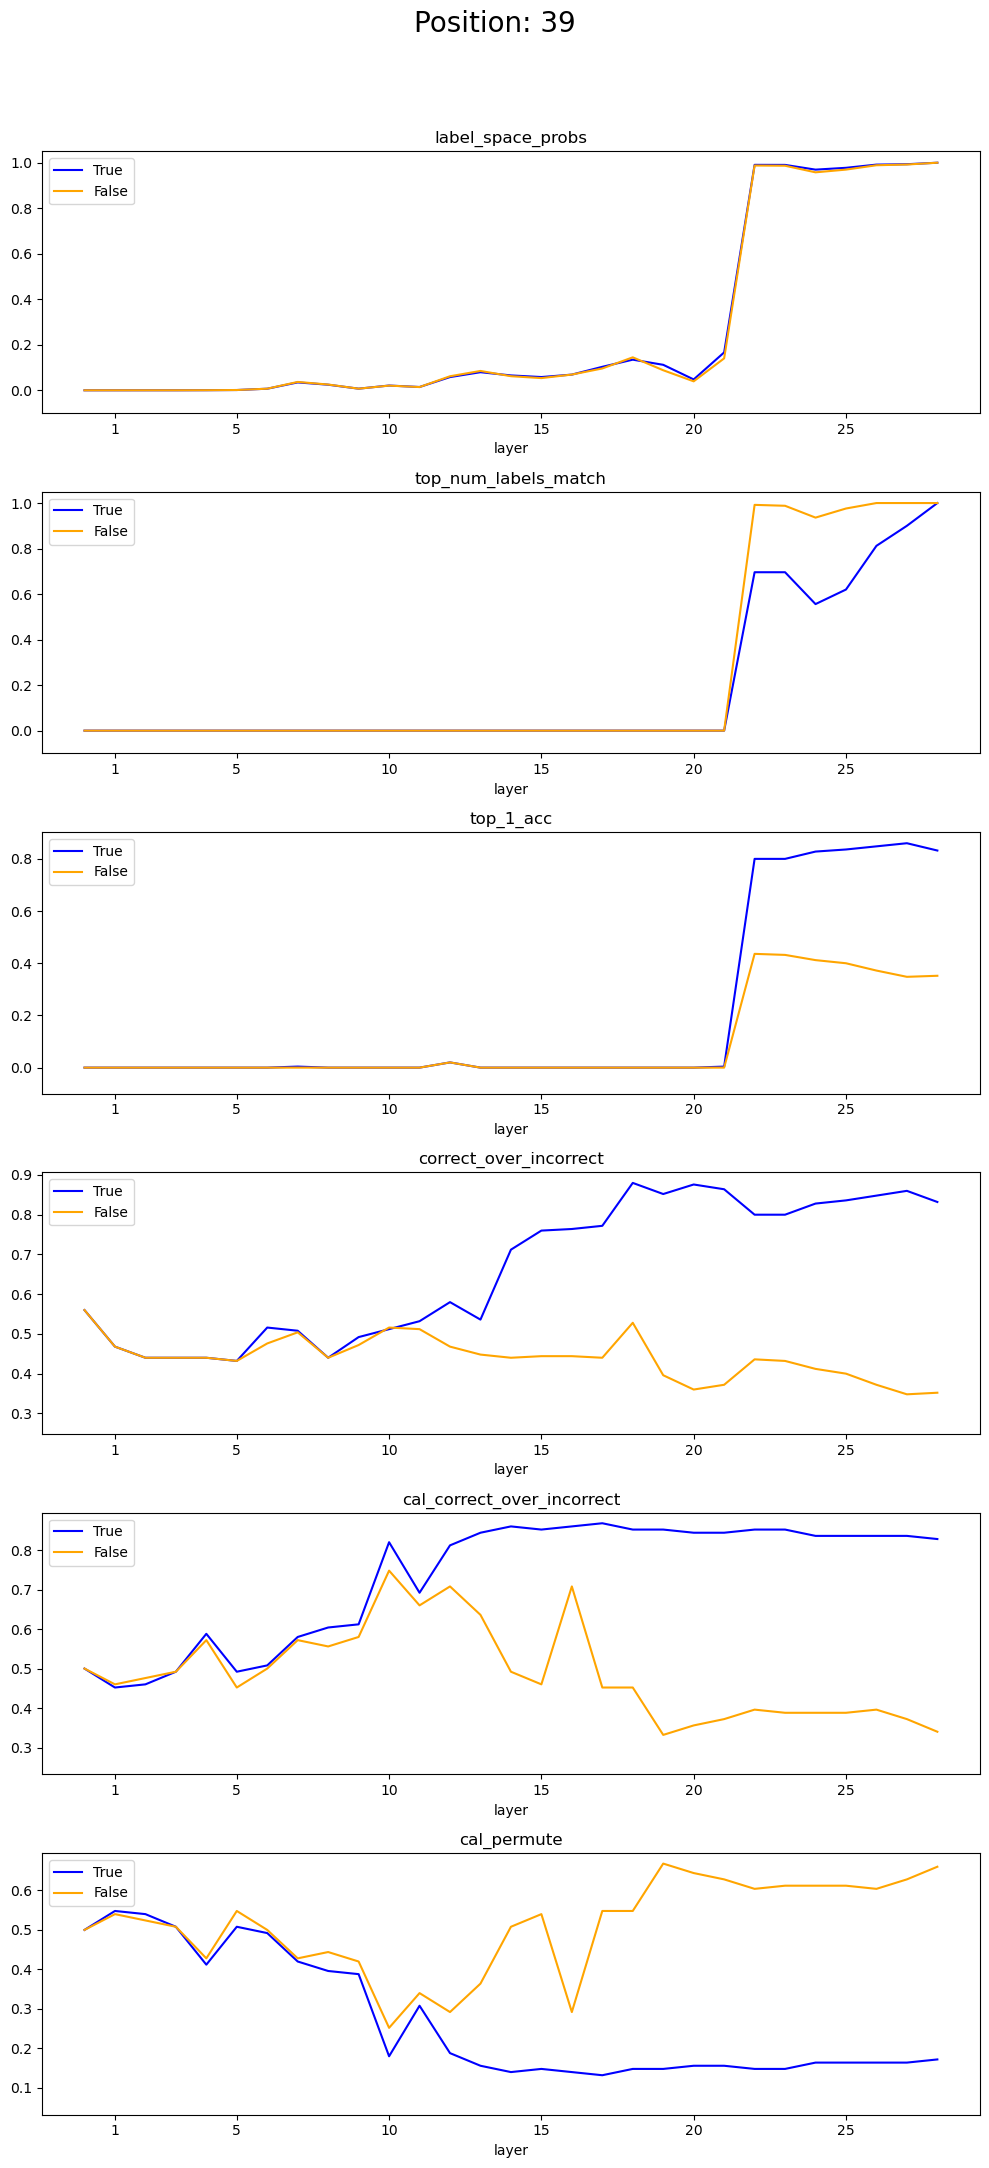

In [23]:
context_pos = model_params["max_demos"] - 1  # index of last demonstration
plot_layerwise_metric_curves(metrics, context_pos=context_pos, show_confidence=False)

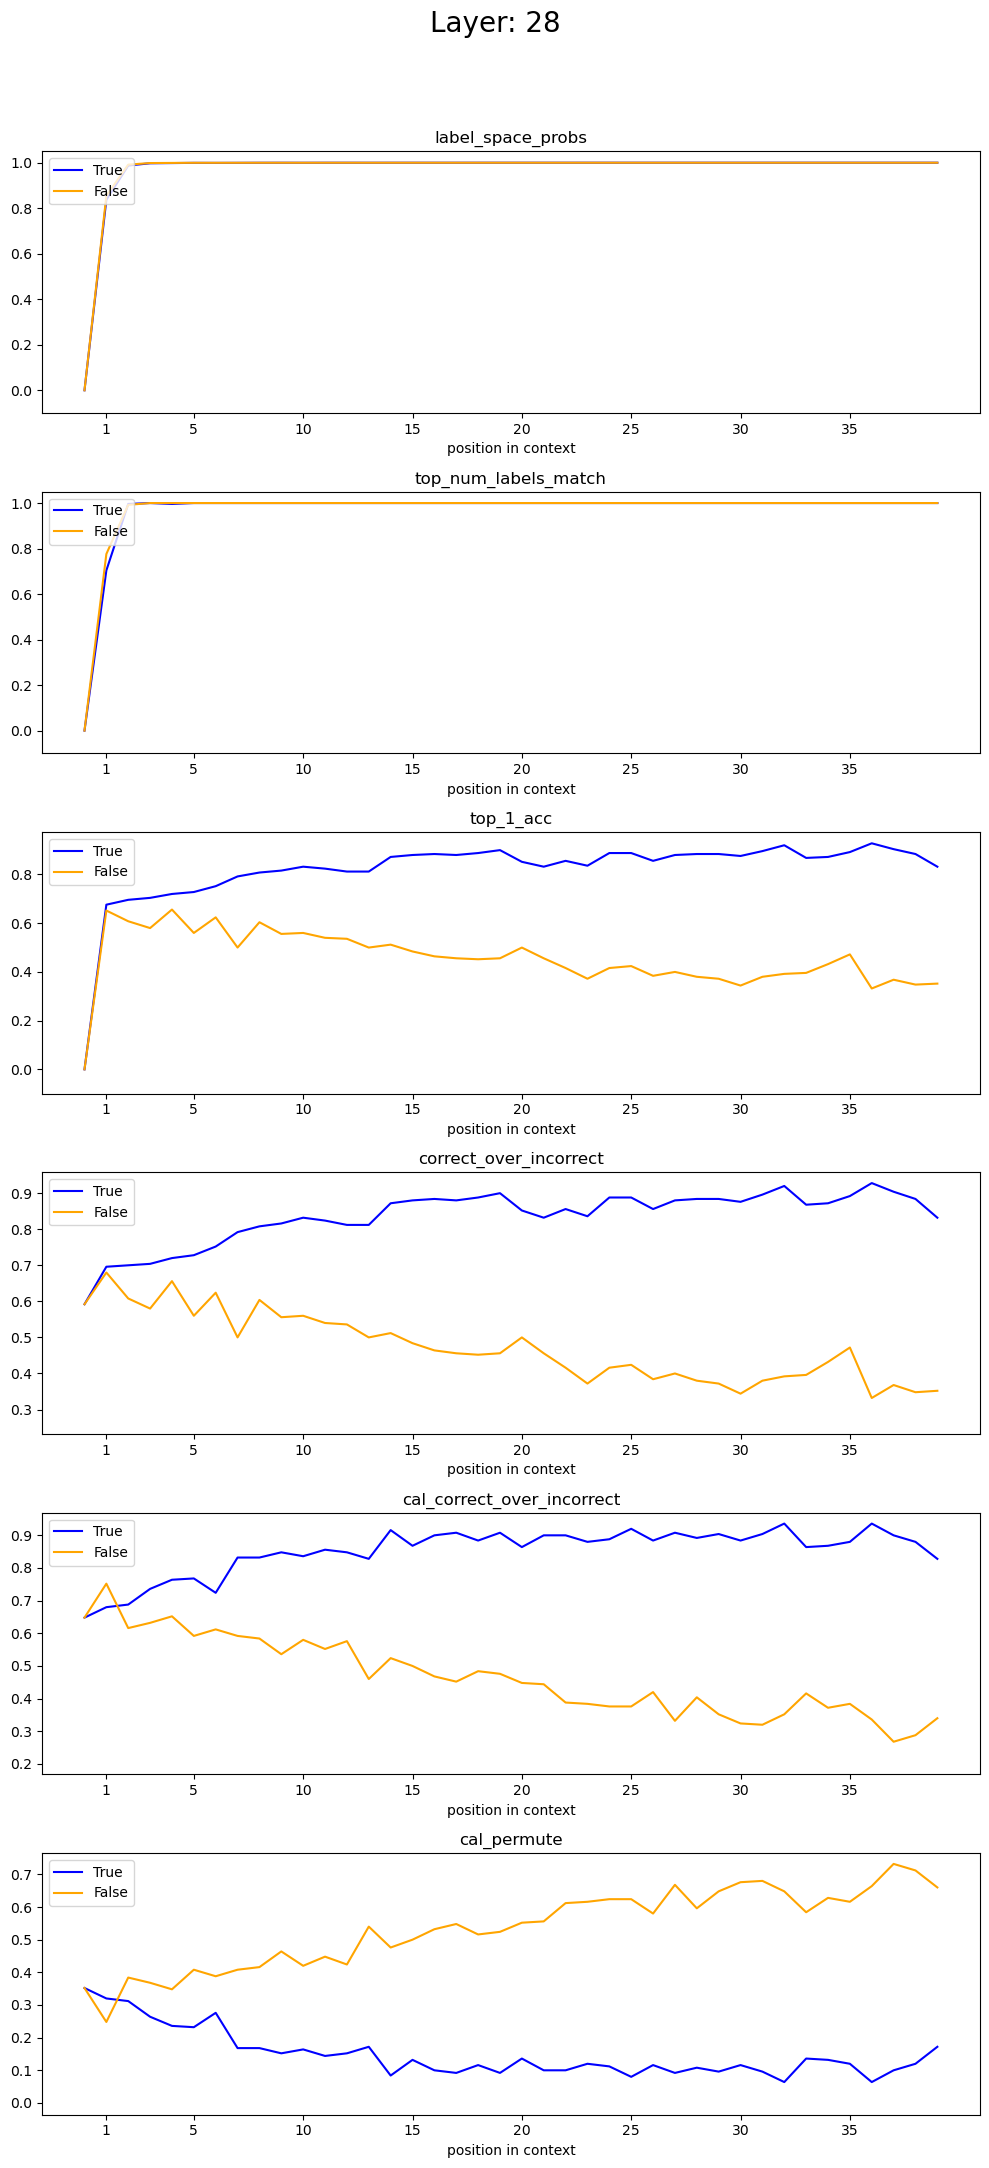

In [24]:
layer = model_params["num_layers"]  # index of last layer
plot_layerwise_metric_curves(metrics, layer=layer, show_confidence=False)